<a href="https://colab.research.google.com/github/sreebalajisree/Fake_News_Detection/blob/main/Fake_News_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [270]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sk-Learn libraries
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score, accuracy_score, classification_report

#Tensorflow libraries for model building, validation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, Input, Activation
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping

#Load the dataset

In [271]:
fake_train = pd.read_excel("/content/sample_data/data/Constraint_English_Train.xlsx")
fake_valid = pd.read_excel("/content/sample_data/data/Constraint_English_Val.xlsx")
fake_test = pd.read_excel("/content/sample_data/data/Constraint_English_Test_without_labels.xlsx")
fake_external1 = pd.read_excel("/content/sample_data/data/external_1.xlsx")
fake_external2 = pd.read_excel("/content/sample_data/data/external_2.xlsx")
df_pseudo = pd.read_csv("/content/sample_data/data/pseudo_submission.csv")

#Helper Function to plot the graph

In [272]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Read the train-set top 5 values

In [273]:
fake_train.head()

,id,tweet,label
0,1.0,The CDC currently reports 99031 deaths. In gen...,real
1,2.0,States reported 1121 deaths a small rise from ...,real
2,3.0,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5.0,Populous states can generate large case counts...,real


Read the test-set top 5 values

In [274]:
fake_test.head()

,id,tweet
0,1.0,Our daily update is published. States reported...
1,2.0,Alfalfa is the only cure for COVID-19.
2,3.0,President Trump Asked What He Would Do If He W...
3,4.0,States reported 630 deaths. We are still seein...
4,5.0,This is the sixth time a global health emergen...


Read the validation-set top 5 values

In [275]:
fake_valid.head()

,id,tweet,label
0,1.0,Chinese converting to Islam after realising th...,fake
1,2.0,11 out of 13 people (from the Diamond Princess...,fake
2,3.0,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4.0,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5.0,6/10 Sky's @EdConwaySky explains the latest #C...,real


#Data preprocessing

In [276]:
#Data preprocessing

def data_process(data):
  for i, label in enumerate(data['label']):
    if(data['label'][i] == "real"):
      data['label'][i] = 1
    else:
      data['label'][i] = 0

In [277]:
fake_train1 = pd.concat([fake_train['tweet'], fake_train['label']], axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'], fake_valid['label']], axis=1)

# Call the data_processing method
data_process(fake_train1)
data_process(fake_valid1)

Read the top 5 values from fake_train1 dataset

In [278]:
fake_train1.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1


Read the top 5 values from fake_valid1 dataset

In [279]:
fake_valid1.head()

,tweet,label
0,Chinese converting to Islam after realising th...,0
1,11 out of 13 people (from the Diamond Princess...,0
2,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,Mike Pence in RNC speech praises Donald Trump’...,0
4,6/10 Sky's @EdConwaySky explains the latest #C...,1


In [280]:
fake_train1.label.value_counts()

1    3360
0    3060
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


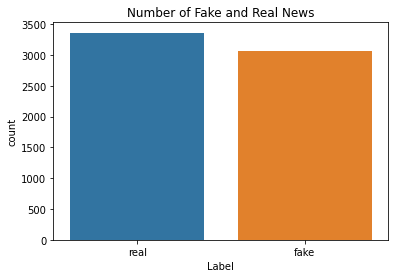

In [281]:
sns.countplot(fake_train.label)
plt.xlabel('Label')
plt.title('Number of Fake and Real News');

#Create the Input and Output Vectors

In [282]:
X = fake_train1.tweet
Y = fake_train1.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

#Split Train, Test Set

In [283]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15, random_state=42, shuffle=True)

#Process the data

*   Tokenize the data and convert the text to sequences.
*   Add padding to ensure that all the sequences have the same shape
*  There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.






In [284]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#Building the Model (Bi-Directional LSTM)

In [285]:
def BiDirect_LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64, return_sequences=True)(layer)
    layer = LSTM(32)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

#Call the function and then compile the model

In [286]:
model = BiDirect_LSTM()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_16 (LSTM)              (None, 150, 64)           29440     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 FC1 (Dense)                 (None, 256)               8448      
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0   

# Fit the training data

In [287]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=12,
          validation_split=0.15)

Epoch 1/12
37/37 [==============================] - 19s 385ms/step - loss: 0.5380 - accuracy: 0.7689 - val_loss: 0.3245 - val_accuracy: 0.8645
Epoch 2/12
37/37 [==============================] - 13s 354ms/step - loss: 0.2569 - accuracy: 0.8965 - val_loss: 0.2375 - val_accuracy: 0.9023
Epoch 3/12
37/37 [==============================] - 12s 328ms/step - loss: 0.1762 - accuracy: 0.9345 - val_loss: 0.2337 - val_accuracy: 0.9096
Epoch 4/12
37/37 [==============================] - 13s 346ms/step - loss: 0.1389 - accuracy: 0.9437 - val_loss: 0.2581 - val_accuracy: 0.9060
Epoch 5/12
37/37 [==============================] - 12s 336ms/step - loss: 0.1233 - accuracy: 0.9530 - val_loss: 0.3122 - val_accuracy: 0.9096
Epoch 6/12
37/37 [==============================] - 12s 328ms/step - loss: 0.1062 - accuracy: 0.9590 - val_loss: 0.3038 - val_accuracy: 0.9060
Epoch 7/12
37/37 [==============================] - 12s 327ms/step - loss: 0.0990 - accuracy: 0.9640 - val_loss: 0.3245 - val_accuracy: 0.9060

#Process the test set data.

In [288]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

#Evaluate the model on the test set.

In [289]:
accr = model.evaluate(test_sequences_matrix,Y_test)

31/31 [==============================] - 1s 42ms/step - loss: 0.3923 - accuracy: 0.8899


In [290]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.392
  Accuracy: 0.890


(0.0, 0.5619763109833003)

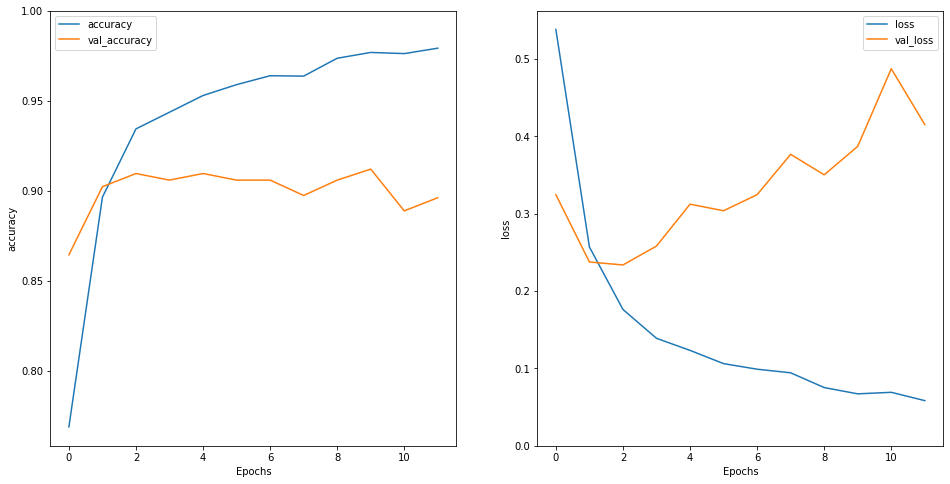

In [291]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [292]:
pred = model.predict(test_sequences_matrix)

In [293]:
print(pred)
print(np.argmax(pred))

[[1.71716809e-02]
 [9.99986291e-01]
 [9.99830306e-01]
 [1.59984720e-05]
 [3.77514720e-01]
 [9.99700725e-01]
 [6.48014545e-01]
 [9.99985814e-01]
 [9.99968410e-01]
 [9.99962091e-01]
 [9.99982715e-01]
 [9.99894500e-01]
 [1.74047142e-01]
 [9.95637476e-01]
 [6.81616366e-02]
 [9.99965310e-01]
 [1.10295587e-04]
 [9.99902248e-01]
 [9.99878824e-01]
 [1.31279230e-04]
 [8.06235373e-02]
 [3.57071996e-01]
 [9.91968989e-01]
 [5.31798601e-03]
 [3.13141346e-02]
 [7.29367730e-06]
 [9.99325871e-01]
 [1.96725130e-04]
 [5.70943058e-02]
 [9.99439359e-01]
 [9.99959290e-01]
 [9.99863982e-01]
 [8.23291302e-01]
 [9.97841716e-01]
 [9.99951243e-01]
 [3.06238830e-02]
 [9.98922110e-01]
 [8.92370641e-02]
 [8.66088271e-03]
 [6.85662308e-05]
 [9.99979138e-01]
 [1.00202988e-05]
 [5.82912151e-07]
 [1.39534771e-02]
 [4.76181507e-04]
 [4.82665211e-01]
 [9.99966085e-01]
 [1.48766339e-02]
 [9.99944448e-01]
 [3.48269939e-04]
 [9.99973357e-01]
 [9.99971271e-01]
 [1.56395417e-05]
 [9.99700904e-01]
 [6.07073307e-04]
 [6.496965

In [294]:
print(classification_report(Y_test, np.argmax(pred,axis=1), labels=[0,1]))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63       447
           1       0.00      0.00      0.00       516

    accuracy                           0.46       963
   macro avg       0.23      0.50      0.32       963
weighted avg       0.22      0.46      0.29       963



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


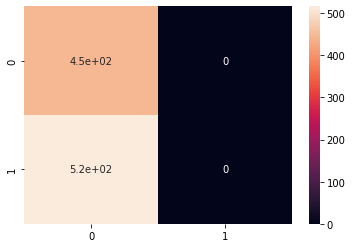

In [295]:
conf_mat = confusion_matrix(Y_test, np.argmax(pred,axis=1), labels=[0,1])
sns.heatmap(conf_mat, annot=True)

In [296]:
text = fake_external1.tweet[1]
new_text = [text]
seq = tok.texts_to_sequences(new_text)
padded = sequence.pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['fake', 'real']

In [297]:
print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.9922597]]
0
fake


In [298]:
fake_external1.head()

,tweet,label
0,Travellers should adhere to strict hygiene mea...,1
1,For the first time in the post-war history of ...,1
2,"Be understing, a Japanese doctor offers excell...",0
3,"drinking lemon water could kill the virus, due...",0
4,Coronavirus Hoax: Fake Virus Pandemic Fabricat...,0


In [299]:
print(text)

For the first time in the post-war history of epidemics, there is a reversal of which countries are most heavily affected by a disease pandemic. By early May, 2020, more than 90% of all reported deaths from coronavirus disease 2019 (COVID-19) have been in the world's richest countries; if China, Brazil, and Iran are included in this group, then that number rises to 96%. The rest of the world—historically far more used to being depicted as the reservoir of pestilence and disease that wealthy countries sought to protect themselves from, and the recipient of generous amounts of advice and modest amounts of aid from rich governments and foundations—looks on warily as COVID-19 moves into these regions.Despite this reversal, however, the usual formula of dispensing guidance continues to be played out, with policies deemed necessary for the hardest-hit wealthy countries becoming a one-size-fits-all message for all countries. Two centrepieces of this approach are the use of widespread lockdown

In [300]:
text1 = fake_valid1.tweet[11]
new_text1 = [text1]
seq1 = tok.texts_to_sequences(new_text1)
padded1 = sequence.pad_sequences(seq1, maxlen=max_len)
pred1 = model.predict(padded1)
labels = ['fake', 'real']

In [301]:
fake_valid[10:15]

,id,tweet,label
10,11.0,You can still fly the friendly skies without f...,real
11,12.0,India records yet another single-day rise of o...,fake
12,13.0,A conspiracy theory audio about #COVID19 testi...,fake
13,14.0,Tomorrow April 6 we will pass 10000 coronaviru...,real
14,15.0,Labour's @Keir_Starmer asks about problems wit...,real


In [302]:
print(text1)

India records yet another single-day rise of over 28000 new cases while more than 5.5 lakh individuals have recovered from COVID-19. Kerala government sets up its first plasma bank in the state following in the steps of Delhi and West Bengal. #COVID19 #CoronavirusFacts https://t.co/JhSQUqMvta


In [303]:
print(pred1)
print(np.argmax(pred1))
print(labels[np.argmax(pred1)])

[[1.2225473e-05]]
0
fake


In [304]:
text2 = fake_valid1.tweet[12]
new_text2 = [text2]
seq2 = tok.texts_to_sequences(new_text2)
padded2 = sequence.pad_sequences(seq2, maxlen=max_len)
pred2 = model.predict(padded1)
labels = ['fake', 'real']

In [305]:
print(text2)

A conspiracy theory audio about #COVID19 testing in #India circulating on @WhatsApp allegedly from MLA Geeta Jain ( @connectGEETA ). We do a quick #FactCheck on this to find that the minister has already clarified on same. https://t.co/SBhSTSr1MH


In [306]:
print(pred2)
print(np.argmax(pred2))
print(labels[np.argmax(pred2)])

[[1.2225473e-05]]
0
fake
